ref: [Defect Detection Using CNN](https://github.com/sadanalog/defect-detection-using-cnn/blob/master/defect-detection-using-cnn.ipynb)

In [1]:
import pandas as pandas
import numpy as np
import glob
import imageio.v2 as imageio    # To ensure code continues to work as expected in the future
import matplotlib.pyplot as plt 
import sklearn
import cv2
from tensorflow.keras import datasets, layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

In [2]:
# Project path
project_path = "tile"

### Peek dataset

Picture shape: (840, 840, 3)
Picture matrix: 
 [[[168 167 164]
  [167 165 160]
  [167 165 157]
  ...
  [127 126 116]
  [126 126 122]
  [124 121 121]]

 [[168 166 164]
  [166 164 160]
  [167 164 157]
  ...
  [138 137 125]
  [136 135 126]
  [132 129 127]]

 [[168 163 163]
  [166 162 159]
  [167 161 156]
  ...
  [143 147 140]
  [140 146 134]
  [136 140 137]]

 ...

 [[131 133 115]
  [113 129 115]
  [114 125 112]
  ...
  [ 56  55  55]
  [ 56  52  51]
  [ 60  52  51]]

 [[130 128 111]
  [109 122 108]
  [110 118  96]
  ...
  [ 58  58  54]
  [ 58  54  53]
  [ 60  55  53]]

 [[133 122 110]
  [109 116 107]
  [109 110  94]
  ...
  [ 63  63  57]
  [ 63  59  56]
  [ 60  59  56]]]


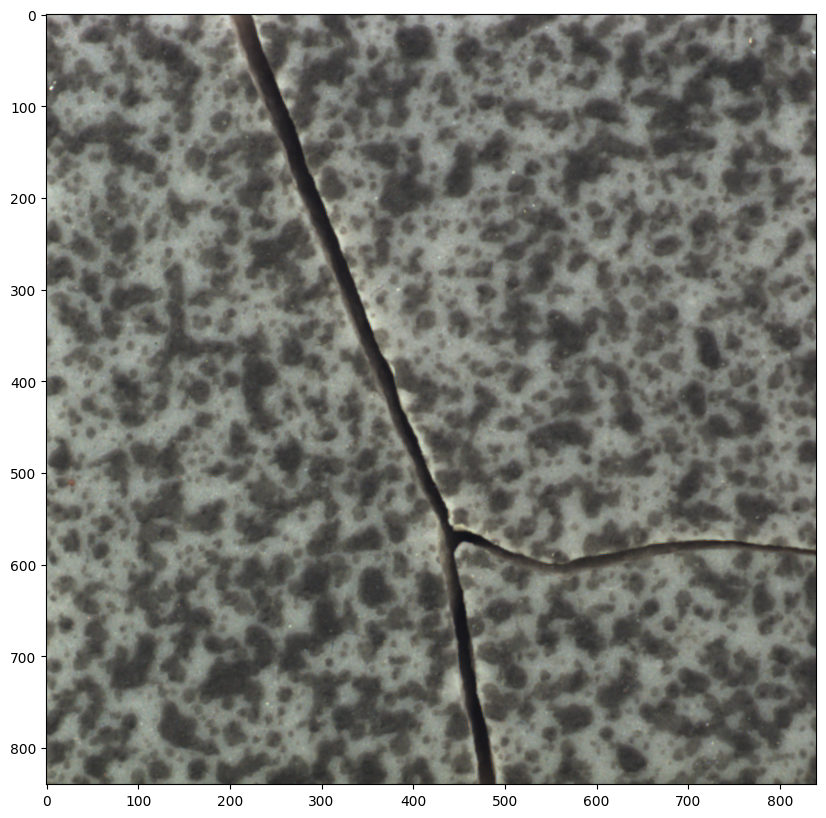

In [3]:
# Load a picture
pic = project_path + "/test/crack/000.png"
im = imageio.imread(pic)
print("Picture shape: {}".format(im.shape))
print("Picture matrix: \n {}".format(im))

# Set display size
plt.figure(figsize=(20,10))
plt.imshow(im, cmap='gray')
plt.show()

## Load Dataset

In [4]:
import cv2

def load_file(file_path, label):
    
    """
    TODO: load the file then create the dict object and append to list
    Return: numpyarray
    Description: object {
                  "name" : file name
                  "label" : label
                  "data" : image
                  }
    """

    # declare the folder name
    folder_name = file_path.split("/")[-1]
    # declare output list
    out_list = []
    # load every file that .png format
    for image_path in glob.glob(file_path + "/*.png"):
        # read image file
        image = imageio.imread(image_path)
        # Resize the image
        image = cv2.resize(image, (224, 224))
        # declare temporary dict dtype
        temp = {}
        # set the file name
        temp["name"] = image_path.split("/")[-1]
        # set the file label, 0 for non defect. 1 for defect
        temp["label"] = label

        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:   
            temp["data"] = image[:,:,0].astype("int") 
        except IndexError:
            # normal case
            temp["data"] = image.astype("int")
        # append temp into output list
        out_list.append(temp)
    # print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))
    # convert list into numpy array dtype
    return np.array(out_list)

### Prepare file paths

In [5]:
defect_images_path1 = project_path + "/test/crack"
defect_images_path2 = project_path + "/test/glue_strip"
defect_images_path3 = project_path + "/test/gray_stroke"
defect_images_path4 = project_path + "/test/oil"
defect_images_path5 = project_path + "/test/rough"

non_defect_images_path1 =  project_path + "/test/good"
non_defect_images_path2 =  project_path + "/train/good"

groundtruth_images_path1 =  project_path + "/ground_truth/crack"
groundtruth_images_path2 = project_path + "/ground_truth/glue_strip"
groundtruth_images_path3 = project_path + "/ground_truth/gray_stroke"
groundtruth_images_path4 = project_path + "/ground_truth/oil"
groundtruth_images_path5 = project_path + "/ground_truth/rough"

### Load Files

In [6]:
defect_images1 = load_file(file_path=defect_images_path1, label=1)
defect_images2 = load_file(file_path=defect_images_path2, label=1)
defect_images3 = load_file(file_path=defect_images_path3, label=1)
defect_images4 = load_file(file_path=defect_images_path4, label=1)
defect_images5 = load_file(file_path=defect_images_path5, label=1)

non_defect_images1 = load_file(file_path=non_defect_images_path1, label=0)
non_defect_images2 = load_file(file_path=non_defect_images_path2, label=0)

groundtruth_images1 = load_file(file_path=groundtruth_images_path1, label=-1)
groundtruth_images2 = load_file(file_path=groundtruth_images_path2, label=-1)
groundtruth_images3 = load_file(file_path=groundtruth_images_path3, label=-1)
groundtruth_images4 = load_file(file_path=groundtruth_images_path4, label=-1)
groundtruth_images5 = load_file(file_path=groundtruth_images_path5, label=-1)

loading file from folder: crack is successful
loading file from folder: glue_strip is successful
loading file from folder: gray_stroke is successful
loading file from folder: oil is successful
loading file from folder: rough is successful
loading file from folder: good is successful
loading file from folder: good is successful
loading file from folder: crack is successful
loading file from folder: glue_strip is successful
loading file from folder: gray_stroke is successful
loading file from folder: oil is successful
loading file from folder: rough is successful


In [7]:
# contribute the non defect dataset into one file
non_defect_images = np.concatenate((non_defect_images1, non_defect_images2))

# contribute the defect dataset into one file
defect_images = np.concatenate((defect_images1, defect_images2))
defect_images = np.concatenate((defect_images, defect_images3))
defect_images = np.concatenate((defect_images, defect_images4))
defect_images = np.concatenate((defect_images, defect_images5))

# contribute the ground truth dataset into one file
groundtruth_images = np.concatenate((groundtruth_images1, groundtruth_images2))
groundtruth_images = np.concatenate((groundtruth_images, groundtruth_images3))
groundtruth_images = np.concatenate((groundtruth_images, groundtruth_images4))
groundtruth_images = np.concatenate((groundtruth_images, groundtruth_images5))
     

In [8]:
print("defect_images.shape: {}\nnon_defect_images.shape: {}\nmask_images.shape:{} \n".format(defect_images.shape, non_defect_images.shape, groundtruth_images.shape))

defect_images.shape: (84,)
non_defect_images.shape: (263,)
mask_images.shape:(84,) 



Display some of the images

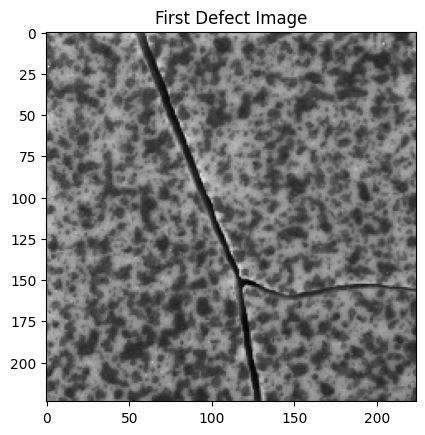

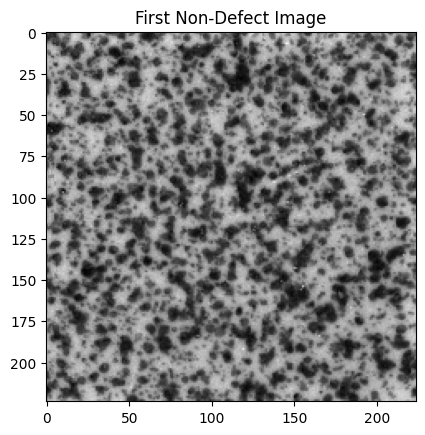

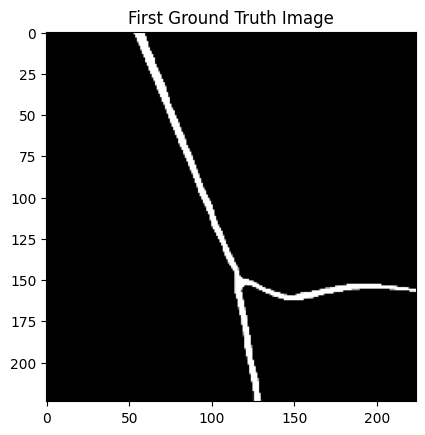

In [9]:
import matplotlib.pyplot as plt

# Display the first defect image
plt.imshow(defect_images[0]['data'], cmap='gray')
plt.title('First Defect Image')
plt.show()

# Display the first non-defect image
plt.imshow(non_defect_images[0]['data'], cmap='gray')
plt.title('First Non-Defect Image')
plt.show()

# Display the first ground truth image
plt.imshow(groundtruth_images[0]['data'], cmap='gray')
plt.title('First Ground Truth Image')
plt.show()

## Data Preparation

In [10]:
# Shuffle the order of defect-free and defect images
np.random.shuffle(non_defect_images)
np.random.shuffle(defect_images)

# The class size is the min length compared with defect-free and defect images
class_size = defect_images.shape[0] if defect_images.shape[0] <= non_defect_images.shape[0] else non_defect_images.shape[0]

# Declare dataset by concat defect_images and non_defect_images with length 0 to class_size
dataset = np.concatenate((defect_images[:class_size], non_defect_images[:class_size]))

# Create an empty matrix X with is matrix of 256x4096 and has dataset length row
X = np.empty([dataset.shape[0], 224, 224]).astype(int)

# Create vector y which has dataset length
y = np.zeros(dataset.shape[0], dtype=int)

# Assign the X,y one-by-one
for i in range(dataset.shape[0]):
    X[i] = dataset[i]["data"]
    y[i] = dataset[i]["label"]

# Since Keras acquire the Image input is a tensor type -> we reshape X
X = X.reshape(X.shape[0], 224, 224, 1)

# Display size of the label 0 and label 1 
np.unique(y, return_counts=True)

(array([0, 1]), array([84, 84], dtype=int64))

### Create CNN Model

In [11]:
from tensorflow.keras import datasets, layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input

In [24]:
def create_model(image_shape=(224, 224, 1), print_summary=False):
    # initial model
    model = models.Sequential()
    # Input layer
    model.add(layers.Input(shape=image_shape))

    # CONV layer: filter 16, stride 7x7
    model.add(layers.Conv2D(16, (7, 7)))
    # activation layer 
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (5, 5), padding="same"))
    # activation layer 
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), padding="same"))
    # activation layer 
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    
    # flatten later -> from matrix to vector
    model.add(layers.Flatten())
    
    # fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(64))
    # activation layer 
    model.add(layers.Activation('relu'))
    
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    
    # set model compiler
    model.compile(optimizer='Adam',  
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [32]:
def train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size):
    # train CNN model
    # batch size to reduce memory usage
    # set early stopping to avoid overfitting
    
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=2)
    filepath = project_path + "/model/weights-best.keras"
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, earlystopping]

    history = model.fit(xtrain, ytrain, epochs=n_epoch, batch_size=batch_size, validation_data=(xval, yval), callbacks=[callbacks_list])
    return history

# Usage
history = train_model(create_model(), xtrain, ytrain, xval, yval, n_epoch, batch_size)
model = create_model(image_shape=(224, 224, 1))
model.summary()

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4028 - loss: 66.9650
Epoch 1: val_accuracy improved from -inf to 0.53571, saving model to C:/mvtec_anomaly_detection/tile/model/weights-best.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.4055 - loss: 65.0246 - val_accuracy: 0.5357 - val_loss: 0.7279
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4248 - loss: 2.2351
Epoch 2: val_accuracy did not improve from 0.53571
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4264 - loss: 2.1929 - val_accuracy: 0.5000 - val_loss: 0.8485
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5881 - loss: 0.6852
Epoch 3: val_accuracy did not improve from 0.53571
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5961 - loss: 0.6813 - val_accuracy: 0.5000 - val_loss: 0.7281


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_93 (Conv2D)              │ (None, 218, 218, 16)   │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_124 (Activation)     │ (None, 218, 218, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 109, 109, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 109, 109, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_125 (Activation)     │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 54, 54, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_126 (Activation)     │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_95 (MaxPooling2D) │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │     2,986,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_127 (Activation)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,018,241 (11.51 MB)

 Trainable params: 3,018,241 (11.51 MB)

 Non-trainable params: 0 (0.00 B)

## Evaluate CNN Model

In [33]:
from sklearn.model_selection import StratifiedKFold
     

# set number of split
kfold_splits = 6
# set number of epoch
n_epoch = 10
# set batch size
batch_size = 10

# create StratifiedKFold
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
    print("Training on fold {}/{}...".format(index+1, kfold_splits))

    # declare x train and x validate
    xtrain, xval = X[train_indices], X[val_indices]
    # declare y train and y validate
    ytrain, yval = y[train_indices], y[val_indices]

    # print number of class portion
    print("ytrain: number of samples each class: {}".format(np.unique(ytrain, return_counts=True)))
    print("yval: number of samples each class: {}".format(np.unique(yval, return_counts=True)))

    # clear the model
    model = None
    # create cnn model
    model = create_model()

    print("Training new iteration on {} training samples, {} validation samples, this may be a while...".format(xtrain.shape[0], xval.shape[0]))

    # train CNN model
    history = train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size)

    print("--------------------------------------------------------------------")


Training on fold 1/6...
ytrain: number of samples each class: (array([0, 1]), array([70, 70], dtype=int64))
yval: number of samples each class: (array([0, 1]), array([14, 14], dtype=int64))
Training new iteration on 140 training samples, 28 validation samples, this may be a while...
Epoch 1/10
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5020 - loss: 139.8965
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to C:/mvtec_anomaly_detection/tile/model/weights-best.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5055 - loss: 130.4185 - val_accuracy: 0.5000 - val_loss: 12.9952
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4878 - loss: 7.4735
Epoch 2: val_accuracy did not improve from 0.50000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4881 - loss: 7.2623 - val_accuracy: 0.4643 - val_loss: 0.7275
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4308 - loss: 0.9378
Epoch 3: val_accuracy improved from 0.50000 to 

## Train and Export CNN Model

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print("y_train: number of samples each class: {}".format(np.unique(y_train, return_counts=True)))
print("y_test: number of samples each class: {}\n".format(np.unique(y_test, return_counts=True)))
     
cnn_model = None
cnn_model = create_model(image_shape=(224, 224, 1))
     

earlystopping = EarlyStopping(monitor='val_accuracy', patience=2)
filepath = project_path + "/model/weights_best.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, earlystopping]
     

cnn_model.fit(X_train, y_train, batch_size=32, epochs=16, validation_split=0.2, callbacks=callbacks_list)

y_train: number of samples each class: (array([0, 1]), array([73, 69], dtype=int64))
y_test: number of samples each class: (array([0, 1]), array([11, 15], dtype=int64))



Epoch 1/16
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5338 - loss: 173.7404
Epoch 1: val_accuracy improved from -inf to 0.41379, saving model to C:/mvtec_anomaly_detection/tile/model/weights_best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.5332 - loss: 181.0352 - val_accuracy: 0.4138 - val_loss: 87.0702
Epoch 2/16
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5106 - loss: 52.7234
Epoch 2: val_accuracy improved from 0.41379 to 0.58621, saving model to C:/mvtec_anomaly_detection/tile/model/weights_best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.5076 - loss: 50.0993 - val_accuracy: 0.5862 - val_loss: 8.9121
Epoch 3/16
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5102 - loss: 8.9979
Epoch 3: val_accuracy did not improve from 0.58621
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.5091 - loss: 8.7963 - val_accuracy: 0.5862 - val_loss: 3.6696
Epoch 4/16
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5223 - loss: 4.4825
Epoch 

## Load Model

In [35]:
cnn_model1 = create_model()
cnn_model1.load_weights(project_path + "/model/weights_best.keras")

# Evaluate the loaded model
score, acc = cnn_model1.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {score}, Test Accuracy: {acc}")

C:\Users\sofea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.4231 - loss: 11.7053
Test Loss: 11.70527172088623, Test Accuracy: 0.42307692766189575
